# Training a Neural Network

In this homework, our objective is to implement a simple neural network from scratch, in particular, error backpropagation and the gradient descent optimization procedure. We first import some useful libraries.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn.datasets
np.random.seed(0)

We consider a two-dimensional moon dataset on which to train the network. We also create a grid dataset which we will use to visualize the decision function in two dimensions. We denote our two inputs as $x_1$ and $x_2$ and use the suffix `d` and `g` to designate the actual dataset and the grid dataset.

In [2]:
# Create a moon dataset on which to train the neural network
X_data, T_label = sklearn.datasets.make_moons(n_samples=100)
X_data = X_data * 2 - 1
T_label = T_label * 2 - 1
X_dim1 = X_data[:, 0]
X_dim2 = X_data[:, 1]

# Creates a grid dataset on which to inspect the decision function
linspace = np.linspace(-4, 4, 100)
X1_grid, X2_grid = np.meshgrid(linspace, linspace)

The moon dataset is plotted below along with some dummy decision function $x_1+x_2=0$.

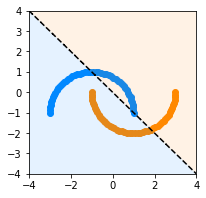

In [3]:
def plot(decision_function, title=None):
    plt.figure(figsize=(3, 3))
    plt.scatter(*X_data[T_label == -1].T, color='#0088FF')
    plt.scatter(*X_data[T_label == 1].T, color='#FF8800')
    plt.contour(X1_grid, X2_grid, decision_function, levels=[0], colors='black', linestyles='dashed')
    plt.contourf(X1_grid, X2_grid, decision_function, levels=[-100, 0, 100], colors=['#0088FF', '#FF8800'], alpha=0.1)
    if title is not None: plt.title(title)
    plt.show()

dummy_decision_function = X1_grid + X2_grid
plot(dummy_decision_function) # plot the dummy decision function

## Part 1: Implementing Error Backpropagation (30 P)

We would like to implement the neural network with the equations:
\begin{align*}
\forall_{j=1}^{25}:~ z_j &= x_1 w_{1j} + x_2 w_{2j} + b_j\\
\forall_{j=1}^{25}:~a_j &= \max(0,z_j)\\
y &= \sum_{j=1}^{25} a_j v_j
\end{align*}
where $x_1,x_2$ are the two input variables and $y$ is the output of the network. The parameters of the neural network are initialized randomly using the normal distributions $w_{ij} \sim \mathcal{N}(\mu=0,\sigma^2=1/2)$, $b_{j} \sim \mathcal{N}(\mu=0,\sigma^2=1)$, $v_{j} \sim \mathcal{N}(\mu=0,\sigma^2=1/25)$. The following code initializes the parameters of the network and implements the forward pass defined above. The neural network is composed of 50 neurons.

In [4]:
n_neurons = 50
n_dim = 2

W = np.random.normal(0, 1 / 2**.5, [n_dim, n_neurons])
B = np.random.normal(0, 1, [n_neurons])
V = np.random.normal(0, 1 / n_neurons**.5, [n_neurons])  # what is V???

def forward(X_dim1, X_dim2):
    X = np.array([X_dim1.flatten(), X_dim2.flatten()]).T # Convert meshgrid into dataset
    Z = X @ W + B
    A = np.maximum(0, Z)
    Y = A @ V
    return Y.reshape(X_dim1.shape)  # Reshape output into meshgrid

We now consider the task of training the neural network to classify the data. For this, we define the error function:
$$
\mathcal{E}(\theta) = \sum_{k=1}^N \max(0,-y^{(k)} t^{(k)})
$$
where $N$ is the number of data points, $y$ is the output of the network and $t$ is the label.

**Task:**

 * **Complete the function below so that it returns the gradient of the error w.r.t. the parameters of the model.**

\begin{align}
\frac{\partial \mathcal{E}}{\partial Y} =& \frac{\partial}{\partial Y} \left(\sum_{k=1}^N \max(0,-YT) \right) = -T\\ \\

\frac{\partial \mathcal{E}}{\partial V} =& \frac{\partial \mathcal{E}}{\partial Y} \cdot \frac{\partial Y}{\partial V}  = -T \cdot \frac{\partial Y}{\partial V}  = -T \cdot \frac{\partial AV}{\partial V}  = -AT\\\\

\frac{\partial \mathcal{E}}{\partial B} =& \frac{\partial \mathcal{E}}{\partial Y} \cdot \frac{\partial Y}{\partial V} \cdot \frac{\partial A}{\partial B}  = \frac{\partial \mathcal{E}}{\partial V} \frac{\partial g(Z)}{\partial B}= \frac{\partial \mathcal{E}}{\partial V} \frac{\partial g(XW+B)}{\partial B}= \frac{\partial \mathcal{E}}{\partial V} \cdot g'(XW+B)\cdot1\\\\

\frac{\partial \mathcal{E}}{\partial W} =& \frac{\partial \mathcal{E}}{\partial Y} \cdot \frac{\partial Y}{\partial V} \cdot \frac{\partial A}{\partial W}  = \frac{\partial \mathcal{E}}{\partial V} \frac{\partial g(Z)}{\partial B}= \frac{\partial \mathcal{E}}{\partial V} \frac{\partial g(XW+B)}{\partial B}= \frac{\partial \mathcal{E}}{\partial V} \cdot g'(XW+B)\cdot X
\end{align}

Activation function:
\begin{align}
g(Z)=&ReLu(Z)=\max(0, Z)\\
g'(Z)=& \text{0 if Z < 0 and 1 otherwise}
\end{align}


In [5]:
def backprop(X_dim1, X_dim2, T_label):
    X = np.array([X_dim1.flatten(), X_dim2.flatten()]).T

    # Compute activations
    Z = X @ W + B
    A = np.maximum(0, Z)
    # Y = A @ V
    
    # Compute backward pass
    # dY = (-Y*T_label > 0) * (-T_label)  # ???
    # dZ = np.outer(dY, V) * (Z > 0)  # ???
    
    # Compute parameter gradients (averaged over the whole dataset)
    g_prime = lambda x: (x > 0) * 1  # ReLU derivative
    
    dV = -(T_label.T * A.T).mean(1)
    dB = (dV * g_prime(Z)).mean(0)
    dW = dV * (X.T @ g_prime(Z))
    # dW = dV * (X.mean(0)[:, None] @ g_prime(Z).mean(0)[None, :])
    
    return dW, dB, dV

## Exercise 2: Training with Gradient Descent (20 P)

We would like to use error backpropagation to optimize the parameters of the neural network. The code below optimizes the network for $128$ iterations and at some chosen iterations plots the decision function along with the current error.

**Task:**
 * **Complete the procedure above to perform at each iteration a step along the gradient in the parameter space. A good choice of learning rate is $\eta=0.1$.**

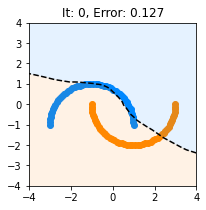

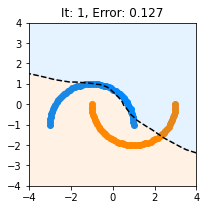

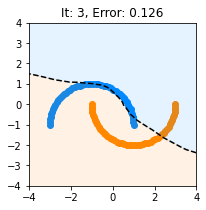

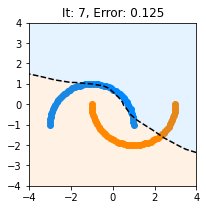

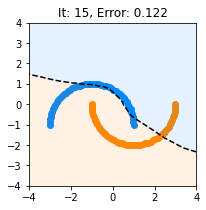

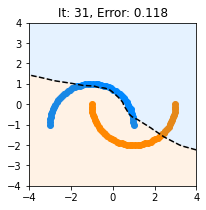

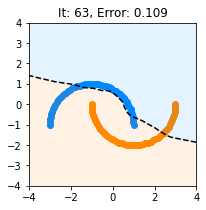

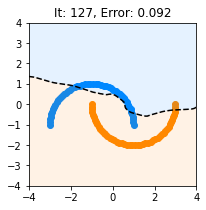

In [6]:
# eta = .1
eta = .00009
for iteration in range(128):
    if iteration in [0, 1, 3, 7, 15, 31, 63, 127]:
        Y_grid = forward(X1_grid, X2_grid)
        Y_data = forward(X_dim1, X_dim2)
        Error_data = np.maximum(0, -Y_data * T_label).mean()
        plot(Y_grid, title="It: %d, Error: %.3f" % (iteration, Error_data))
    dW, dB, dV = backprop(X_dim1, X_dim2, T_label)
    W = W - eta * dW
    B = B - eta * dB
    V = V - eta * dV